# Определение возраста покупателей

## Постановка задачи

Сетевой супермаркет «Хлеб-Соль» хочет внедрить систему компьютерного зрения для обработки фотографий покупателей.  

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 
В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [50]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure 
import numpy as np


from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Прочитаем данные и выведем первые 5 строк, чтобы посмотрерть корректность прочитанного файла

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Построем диаграмму распределения количества фотографий по возрасту

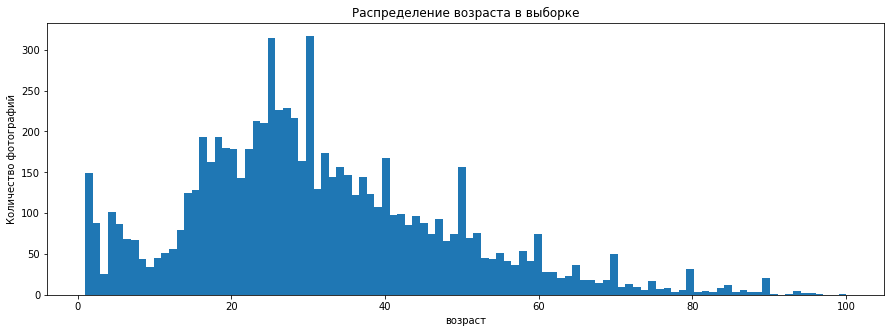

In [57]:
plt.figure(figsize=(15,5))
labels['real_age'].plot(kind='hist', bins=100, range= (labels['real_age'].min(), labels['real_age'].max()))
plt.xlabel('возраст')
plt.ylabel('Количество фотографий')
plt.title('Распределение возраста в выборке')
plt.show()

Выведем статистические параметры столбца с возрастом

In [4]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Посмотрим Топ-10 возрастов по количеству фотографий:

In [5]:
labels['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Из графика видно и произведенных наблюдений видно, что:  
- Общее количество фотографий 7591!
- Фотографии людей с возрастом 30 и 25 лет встречаются максимально часто;
- Средний возраст людей на фотографиях 31 год, а медиана 29. Это означает, что выборка больше смещена вправо;
- Минимальный возраст 1 год, максимальный - 100.

Напишем функцию для загрузки фотографий из директории:
- Укажем размер фотографий (224х224);
- Фотографии загрузим батчами по 32 фотографии;

In [8]:
def load_train(patch):
    df = pd.read_csv(patch+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                           directory = patch+'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           seed=12345,
                                                           shuffle=False)
    return train_datagen_flow

In [9]:
train_ds = load_train('/datasets/faces/')

Found 7591 validated image filenames.


Посмотрим структуру переменной **train_ds**:
train_ds - массив, разбитый на батчи:
- первая координата является четырехмерным массивом, и хранит в себе информацию о 32 фотографиях, их размерах и количестве каналов:

In [32]:
train_ds[4][0].shape

(32, 224, 224, 3)

- вторая координата хранит информацию о возрасте человека, указанного на фотографии.

In [38]:
train_ds[4][1]

array([26, 16,  5, 60, 43, 24, 42, 26, 54, 52, 24, 23, 26, 18, 54,  4, 23,
       30, 23,  8, 40, 52, 37,  1, 25, 20, 28, 60, 34, 48,  1, 18])

Загрузим в переменные **features_train** и **target_train** данные одного батча

In [35]:
features_train, target_train = next(train_ds)

In [40]:
features_train.shape

(32, 224, 224, 3)

In [36]:
target_train

array([ 4, 18, 80, 50, 17, 27, 24, 43, 26, 39, 17, 51,  2,  1,  6, 18, 24,
        5, 40, 16, 29,  1, 35, 25,  5, 30, 24, 35, 65, 13,  1, 28])

Выведем первую фотографию в первом батче

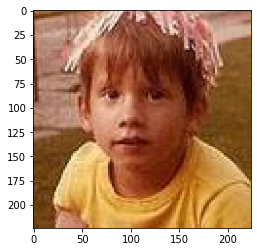

In [48]:
plt.imshow(features_train[0])

Выведем 12 фотографий:

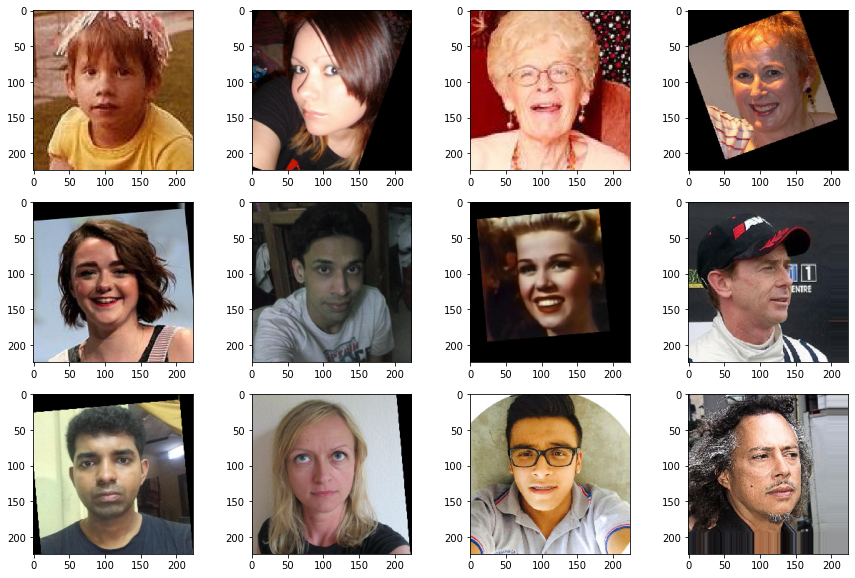

In [49]:
plt.figure(figsize=(15,10))
for i in range(0,12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(features_train[i])

Вывод: 
- Фотогафии имеют предобработку, часть фотографий повернуто, вероятнее, чтобы лицо было вертикально;
- Наибольшее количества фотографий - люди в возрасте 20-30 лет

## Обучение модели

Код обучения модели

```python
#импортируем необходимые библиотеки
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential 
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


# напишем функцию загрузки тренировочных данных
def load_train(path):
    df = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.) # выделим 25% данных на валидацию и стандартизируем значения
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                           directory = path+'final_files/',
                                                           x_col='file_name', 
                                                           y_col='real_age',  
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42,
                                                           shuffle=False)
    return train_datagen_flow

# напишем функцию загрузки тестовых данных
def load_test(path):
    df = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                           directory = path+'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='validation',
                                                           seed=42,
                                                           shuffle=False)
    return test_datagen_flow

# напишем функцию создания модели. Будем использовать предобученную модель ResNet50

def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    optimizer = Adam(lr=0.0001) # укажем шаг = 0.0001
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# напишем функцию обучения модели, выберем количество эпох 10
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 47s - loss: 389.3470 - mae: 14.8013 - val_loss: 706.0129 - val_mae: 21.7029
Epoch 2/10
178/178 - 39s - loss: 77.2933 - mae: 6.6312 - val_loss: 342.7606 - val_mae: 13.8694
Epoch 3/10
178/178 - 39s - loss: 39.6611 - mae: 4.8325 - val_loss: 235.6712 - val_mae: 11.3380
Epoch 4/10
178/178 - 39s - loss: 27.1862 - mae: 4.0036 - val_loss: 113.8029 - val_mae: 7.9682
Epoch 5/10
178/178 - 39s - loss: 21.9113 - mae: 3.6072 - val_loss: 102.7106 - val_mae: 7.5203
Epoch 6/10
178/178 - 39s - loss: 19.6485 - mae: 3.4081 - val_loss: 72.6430 - val_mae: 6.3465
Epoch 7/10
178/178 - 39s - loss: 14.9723 - mae: 2.9643 - val_loss: 80.5843 - val_mae: 6.7014
Epoch 8/10
178/178 - 39s - loss: 11.7817 - mae: 2.6181 - val_loss: 70.8663 - val_mae: 6.3211
Epoch 9/10
178/178 - 39s - loss: 10.1460 - mae: 2.4079 - val_loss: 70.7438 - val_mae: 6.2179
Epoch 10/10
178/178 - 39s - loss: 8.8343 - mae: 2.2448 - val_loss: 78.5709 - val_mae: 6.5132


60/60 - 10s - loss: 78.5709 - mae: 6.5132
Test MAE: 6.5132

```

## Анализ обученной модели

В нашем распоряжении был набор фотографий людей с указанием возраста. 


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека, что позволит:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

В результате обучения модели мы получили метрику **MAE** равную 6,51.  
Это означает, что модель ошибается в среднем на 6 лет. 

Если использовать данную модель для продажи и предложения сопутствующих товаров, то ее можно использовать, т.к. интересы/потребности людей в возрастной вилке 6 лет схожи, но при контроле кассиров за продажу алкоголя модель не будет эффективна, т.к. ошибка в 6 лет является существенным отклоненем.